#**Hiragana Dection**
My goal is to create a machine learning model able to detect a hiragana character.

### Imports

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from urllib.request import urlretrieve
import pandas as pd
import requests
from io import StringIO
import cv2
import albumentations as A
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

### Datasets download

In [3]:
urls = [
    "http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz",
    "http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz",
    "http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-imgs.npz",
    "http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-labels.npz"

]

def download_and_load(url, filename):
    if not os.path.exists(filename):
        urlretrieve(url, filename)
    return np.load(filename)

train_images = download_and_load(urls[0], 'k49-train-imgs.npz')['arr_0']
train_labels = download_and_load(urls[1], 'k49-train-labels.npz')['arr_0']
test_images = download_and_load(urls[2], 'k49-test-imgs.npz')['arr_0']
test_labels = download_and_load(urls[3], 'k49-test-labels.npz')['arr_0']

print(f'Train images shape: {train_images.shape}')
print(f'Train labels shape: {train_labels.shape}')
print(f'Test images shape: {test_images.shape}')
print(f'Test labels shape: {test_labels.shape}')

Train images shape: (232365, 28, 28)
Train labels shape: (232365,)
Test images shape: (38547, 28, 28)
Test labels shape: (38547,)


In [4]:

url = 'http://codh.rois.ac.jp/kmnist/dataset/k49/k49_classmap.csv'

response = requests.get(url)
response.raise_for_status()

data = StringIO(response.text)

df = pd.read_csv(data)



In [ ]:
train_images[0].shape

(28, 28)

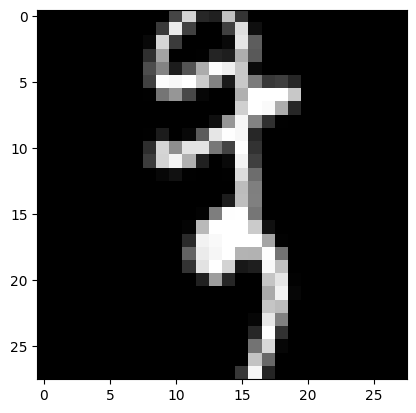

In [ ]:
primeira_imagem = train_images[0]

plt.imshow(primeira_imagem, cmap='gray')
plt.show()

### Creating a translator between hiragana index and hiragana itself

In [ ]:
# Translate  the Label to Japanese
def japanese_translator(index:int):
  valor_codepoint = df.loc[df['index'] == index, 'codepoint'].values[0]
  valor_codepoint
  codigo_unicode_int = int(valor_codepoint[2:], 16)

  # Convert the code to Unidecode Character
  caractere = chr(codigo_unicode_int)

  return caractere

In [ ]:
for i in range(49):
  carac=japanese_translator(i)
  print(carac)

あ
い
う
え
お
か
き
く
け
こ
さ
し
す
せ
そ
た
ち
つ
て
と
な
に
ぬ
ね
の
は
ひ
ふ
へ
ほ
ま
み
む
め
も
や
ゆ
よ
ら
り
る
れ
ろ
わ
ゐ
ゑ
を
ん
ゝ


## Data augmentation

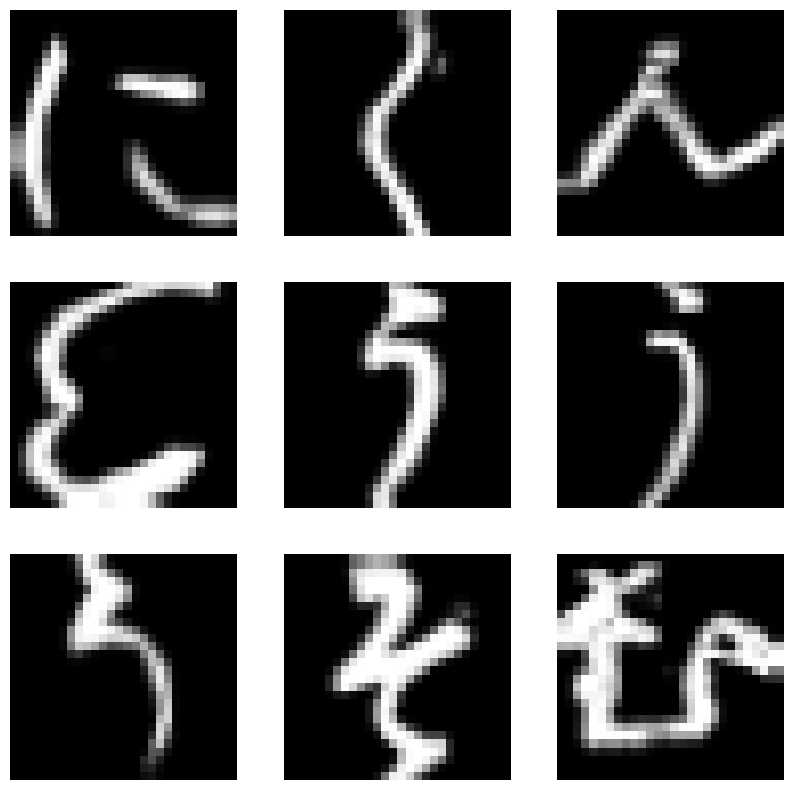

In [ ]:

# Normalize the images to the range [0, 1]
train_images = train_images.astype('float32') / 255.0

# Add a dimension for the channel (to have the format (n_samples, 28, 28, 1))
train_images = np.expand_dims(train_images, -1)

# Convert labels to one-hot encoding
num_classes = len(np.unique(train_labels))
train_labels = to_categorical(train_labels, num_classes=num_classes)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Create an image generator with data augmentation
datagen = ImageDataGenerator(
    rotation_range=5,        # Random rotation up to 5 degrees
    width_shift_range=0.05,  # Horizontal shift up to 5% of the width
    height_shift_range=0.05, # Vertical shift up to 5% of the height
    shear_range=0.05,        # Mild shear
    zoom_range=0.05,         # Gentle Zoom
    fill_mode='nearest'      # Fill empty pixels after transformation
)

# Apply data augmentation to the training set
datagen.fit(X_train)

# Create a data generator for training
train_generator = datagen.flow(X_train, y_train, batch_size=32)

# Create a data generator for validation without data augmentation
val_generator = ImageDataGenerator().flow(X_val, y_val, batch_size=32)

# Display some images to visualize the data augmentation
import matplotlib.pyplot as plt

# Obtain a batch of augmented images
sample_images, sample_labels = next(train_generator)

# Display the augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()


## Model Training





I've made a previous version that had 90% ~ 94% accuracy.(No data augmentation)

Them I come up with a solution to better hiragana filtering.
Before using maxpooling layers in early stages, I use multiple convolution layers to a better separation of features while I still downsize the layers length.

Balanced Accuracy was added as a metrics in the new model as well.

Early Stop with 10 epochs of patience and cross validation.


1. Input layer (Conv2D):

*    Input shape: (28, 28, 1)

*    Output shape: (28, 28, 32)

2. Convolutional layer (Conv2D):

*    Input shape: (28, 28, 32)

*    Output shape: (26, 26, 32)

3. Convolutional layer (Conv2D):

*    Input shape: (26, 26, 32)

*    Output shape: (24, 24, 64)

4. Convolutional layer (Conv2D):

*    Input shape: (24, 24, 64)

*    Output shape: (22, 22, 64)

5. MaxPooling layer (MaxPooling2D):

*    Input shape: (22, 22, 64)

*    Output shape: (11, 11, 64)

6. Convolutional layer (Conv2D):

*    Input shape: (11, 11, 64)

*    Output shape: (11, 11, 64)

7. MaxPooling layer (MaxPooling2D):

*    Input shape: (11, 11, 64)

*    Output shape: (5, 5, 64)

8. Convolutional layer (Conv2D):

*    Input shape: (5, 5, 64)

*    Output shape: (3, 3, 128)

9. Flatten layer (Flatten):

*    Input shape: (3, 3, 128)

*    Output shape: (1152,)

10. Fully connected layer (Dense):

*    Input shape: (1152,)

*    Output shape: (512,)

11. Dropout layer (Dropout):

*    Input shape: (512,)

*    Output shape: (512,)

12. Output layer (Dense):

*    Input shape: (512,)

*    Output shape: (49,)



In [9]:
def balanced_accuracy(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)
    C = tf.math.confusion_matrix(y_true, y_pred)
    diag = tf.linalg.diag_part(C)
    true_num = tf.reduce_sum(C, axis=1)
    per_class = tf.math.divide_no_nan(tf.cast(diag, tf.float32), tf.cast(true_num, tf.float32))
    return tf.math.reduce_mean(per_class)

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), padding="same"),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(49, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', balanced_accuracy])



# Creating the EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model with EarlyStopping
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val), callbacks=[early_stopping])


Epoch 1/200
5810/5810 ━━━━━━━━━━━━━━━━━━━━ 1374s 236ms/step - accuracy: 0.7278 - balanced_accuracy: 0.3442 - loss: 1.0378 - val_accuracy: 0.9474 - val_balanced_accuracy: 0.4505 - val_loss: 0.1946
Epoch 2/200
5810/5810 ━━━━━━━━━━━━━━━━━━━━ 1347s 232ms/step - accuracy: 0.9255 - balanced_accuracy: 0.4404 - loss: 0.2641 - val_accuracy: 0.9580 - val_balanced_accuracy: 0.4559 - val_loss: 0.1547
Epoch 3/200
5810/5810 ━━━━━━━━━━━━━━━━━━━━ 1377s 227ms/step - accuracy: 0.9426 - balanced_accuracy: 0.4491 - loss: 0.2027 - val_accuracy: 0.9644 - val_balanced_accuracy: 0.4590 - val_loss: 0.1331
Epoch 4/200
5810/5810 ━━━━━━━━━━━━━━━━━━━━ 1352s 229ms/step - accuracy: 0.9501 - balanced_accuracy: 0.4520 - loss: 0.1734 - val_accuracy: 0.9662 - val_balanced_accuracy: 0.4603 - val_loss: 0.1303
Epoch 5/200
5810/5810 ━━━━━━━━━━━━━━━━━━━━ 1374s 236ms/step - accuracy: 0.9560 - balanced_accuracy: 0.4558 - loss: 0.1542 - val_accuracy: 0.9677 - val_balanced_accuracy: 0.4608 - val_loss: 0.1226
Epoch 6/200
5810/581

In [ ]:
# Save the architecture
with open('architecture.json', 'w') as json_file:
    json_file.write(model.to_json())

# Save the weights
model.save('hiragana_cnn.keras')


## The Architecture model



1453/1453 ━━━━━━━━━━━━━━━━━━━━ 105s 71ms/step


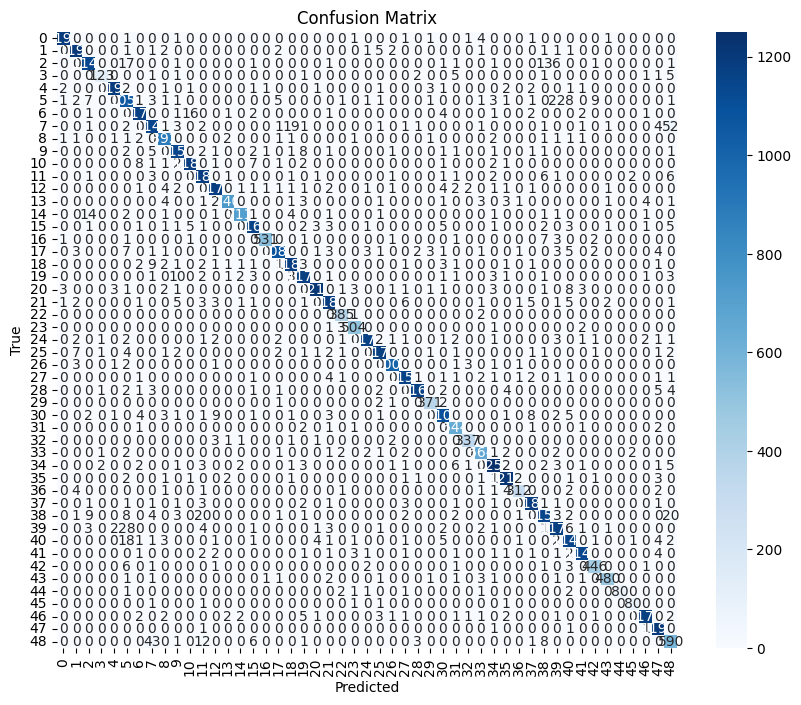

Classification Report:
               precision    recall  f1-score   support

           あ       0.99      0.99      0.99      1207
           い       0.98      0.99      0.98      1215
           う       0.97      0.96      0.96      1186
           え       0.95      0.87      0.91       141
           お       0.99      0.98      0.99      1212
           か       0.90      0.94      0.92      1126
           き       0.98      0.97      0.97      1203
           く       0.93      0.93      0.93      1241
           け       0.97      0.98      0.97       910
           こ       0.97      0.97      0.97      1180
           さ       0.98      0.98      0.98      1207
           し       0.95      0.98      0.96      1208
           す       0.98      0.98      0.98      1207
           せ       0.99      0.97      0.98       766
           そ       0.99      0.96      0.97       740
           た       0.97      0.97      0.97      1198
           ち       0.99      0.97      0.98       549
   

In [ ]:
import seaborn as sns

num_classes = len(np.unique(train_labels))
train_labels = to_categorical(train_labels, num_classes=num_classes)
# Make predictions on the test set
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

# Evaluate Confusion Matrix
conf_matrix = confusion_matrix(y_val_true_classes, y_val_pred_classes)
class_report = classification_report(y_val_true_classes, y_val_pred_classes, target_names=[japanese_translator(i) for i in range(num_classes)])

# Display Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(num_classes)], yticklabels=[str(i) for i in range(num_classes)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n", class_report)